<a href="https://colab.research.google.com/github/Anwesha-dash811/pytorch_projects/blob/main/fruit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATASET ON FRUITS-360

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

# Downloading and exploring the FRUITS-360 dataset

**Exploring the datset and printing the classes present in it**

In [ ]:
data_set = '../input/fruits/fruits-360'
print('Folders :', os.listdir(data_set))

Folders : ['Test', 'papers', 'LICENSE', 'test-multiple_fruits', 'Training', 'readme.md']


In [ ]:
classes = os.listdir(data_set+"/Training")


In [ ]:
print(classes)

['Grapefruit Pink', 'Apple Crimson Snow', 'Potato Red Washed', 'Pineapple', 'Cherry Wax Red', 'Fig', 'Peach Flat', 'Raspberry', 'Maracuja', 'Plum 2', 'Cactus fruit', 'Cherry 2', 'Mandarine', 'Grape White', 'Corn Husk', 'Grape Blue', 'Quince', 'Cucumber Ripe', 'Pear Kaiser', 'Cherry Wax Yellow', 'Avocado ripe', 'Grape White 2', 'Grapefruit White', 'Watermelon', 'Pepino', 'Onion Red Peeled', 'Apple Red Delicious', 'Salak', 'Mango Red', 'Apple Pink Lady', 'Physalis with Husk', 'Pineapple Mini', 'Pear Red', 'Nectarine Flat', 'Onion Red', 'Tamarillo', 'Peach', 'Tomato Yellow', 'Potato Sweet', 'Banana Red', 'Beetroot', 'Apple Red 2', 'Nut Pecan', 'Cauliflower', 'Apple Golden 1', 'Onion White', 'Tomato 2', 'Physalis', 'Grape White 4', 'Nut Forest', 'Redcurrant', 'Apple Red Yellow 1', 'Dates', 'Cocos', 'Tomato 3', 'Apple Granny Smith', 'Kiwi', 'Apple Red Yellow 2', 'Pear Forelle', 'Cherry 1', 'Cantaloupe 2', 'Nectarine', 'Pear Monster', 'Papaya', 'Apple Golden 2', 'Tomato not Ripened', 'Lemon'

**Printing the number of images in training and test dataset**

In [ ]:
dataset = ImageFolder(data_dir + '/Training', transform=ToTensor())
test_dataset = ImageFolder(data_dir + '/Test', transform=ToTensor())

**Number of training dataset**

In [ ]:
print('Size of training dataset :', len(dataset))

Size of training dataset : 67692


**Number of test dataset**

In [ ]:
print('Size of test dataset :', len(test_dataset))

Size of test dataset : 22688


In [ ]:
#number of classes in dataset
num_classes = len(classes)
num_classes

131

In [ ]:
#shape of image tensor from the dataset
img, label = dataset[0]
img_shape = img.shape
img.shape

torch.Size([3, 100, 100])

This dataset consists of 3-channel color images (RGB). Let us look at a sample image from the dataset. matplotlib expects channels to be the last dimension of the image tensors (whereas in PyTorch they are the first dimension), so we'll the .permute tensor method to shift channels to the last dimension. Let's also print the label for the image.

Label (numeric): 0
Label (textual): Grapefruit Pink
Name:  Apple Braeburn


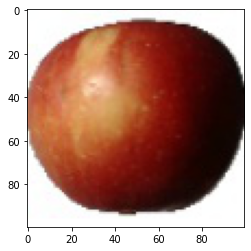

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])
print('Name: ', dataset.classes[label])

Label (numeric): 20
Label (textual): Avocado ripe
Name:  Blueberry


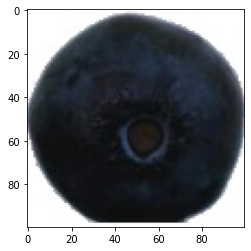

In [ ]:
img, label = dataset[10130]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])
print('Name: ', dataset.classes[label])

Label (numeric): 5
Label (textual): Fig
Name:  Apple Granny Smith


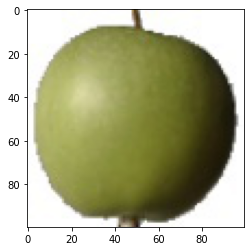

In [ ]:
img, label = dataset[2564]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])
print('Name: ', dataset.classes[label])

# Preparing the dataset for training
We'll use a validation set with 7000 images (10% of the dataset). To ensure we get the same validation set each time, we'll set PyTorch's random number generator to a seed value of 43. 
* The dataset is split into 3 datasets:

* * Training dataset 
* * Test dataset 
* * Validation dataset

In [ ]:
torch.manual_seed(43)
val_size = 7000
train_size = len(dataset) - val_size

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(60692, 7000)

**We can now create data loaders to load the data in batches.**

In [ ]:
batch_size=128

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 3, 100, 100])


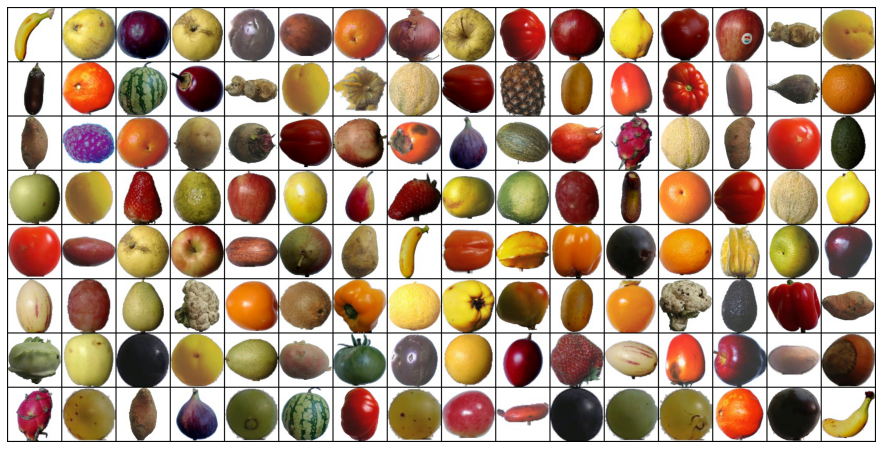

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Creating a model using FNN(Feedforward Neural Networks)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
torch.cuda.is_available()

False

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# Training the model

In [ ]:
input_size = 3*100*100
output_size = 131 

In [ ]:
class Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 244)
        self.linear2 = nn.Linear(244, 122)
        self.linear3 = nn.Linear(122, 61)
        self.linear4 = nn.Linear(61, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        return out
        

In [ ]:
model = to_device(Model(), device)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 4.874212741851807, 'val_acc': 0.006404728163033724}]

In [ ]:
history += fit(2, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 4.8667, val_acc: 0.0134
Epoch [1], val_loss: 4.8667, val_acc: 0.0134


In [ ]:
history += fit(2, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 4.8667, val_acc: 0.0134
Epoch [1], val_loss: 4.8667, val_acc: 0.0134


In [ ]:
history += fit(2, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 4.8667, val_acc: 0.0134
Epoch [1], val_loss: 4.8667, val_acc: 0.0134


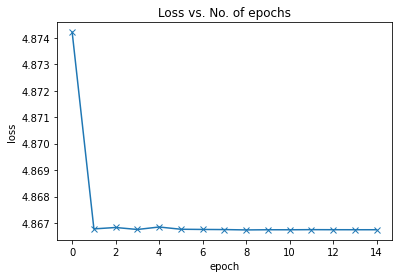

In [ ]:
plot_losses(history)

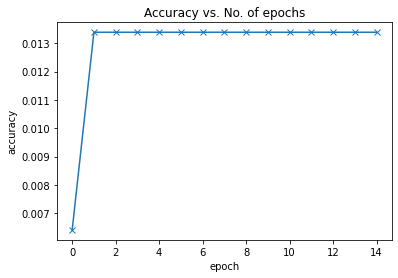

In [ ]:
plot_accuracies(history)

In [ ]:
evaluate(model, test_loader)

{'val_loss': 4.867464065551758, 'val_acc': 0.013342696242034435}